# Train the vgg16 model for phishing detection

## Imports

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = pathlib.Path("../phi_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

In [3]:
os.listdir(dataset_dir)

['phishing', 'trusted_list']

In [4]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-07-25_21;43;09.524444


## Params

In [5]:
model_name = "vgg16"
batch_size = 32
img_height = 224
img_width = 224

rest_split_ratio = 0.2
test_split_ratio = 0.2

## Load dataset

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 8433 files for training.


In [27]:
rest_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 2108 files for validation.


In [28]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

66


In [29]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio // batch_size))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio // batch_size))

In [30]:
class_names = train_ds.class_names

In [31]:
class_names

['phishing', 'trusted_list']

## Visualize data

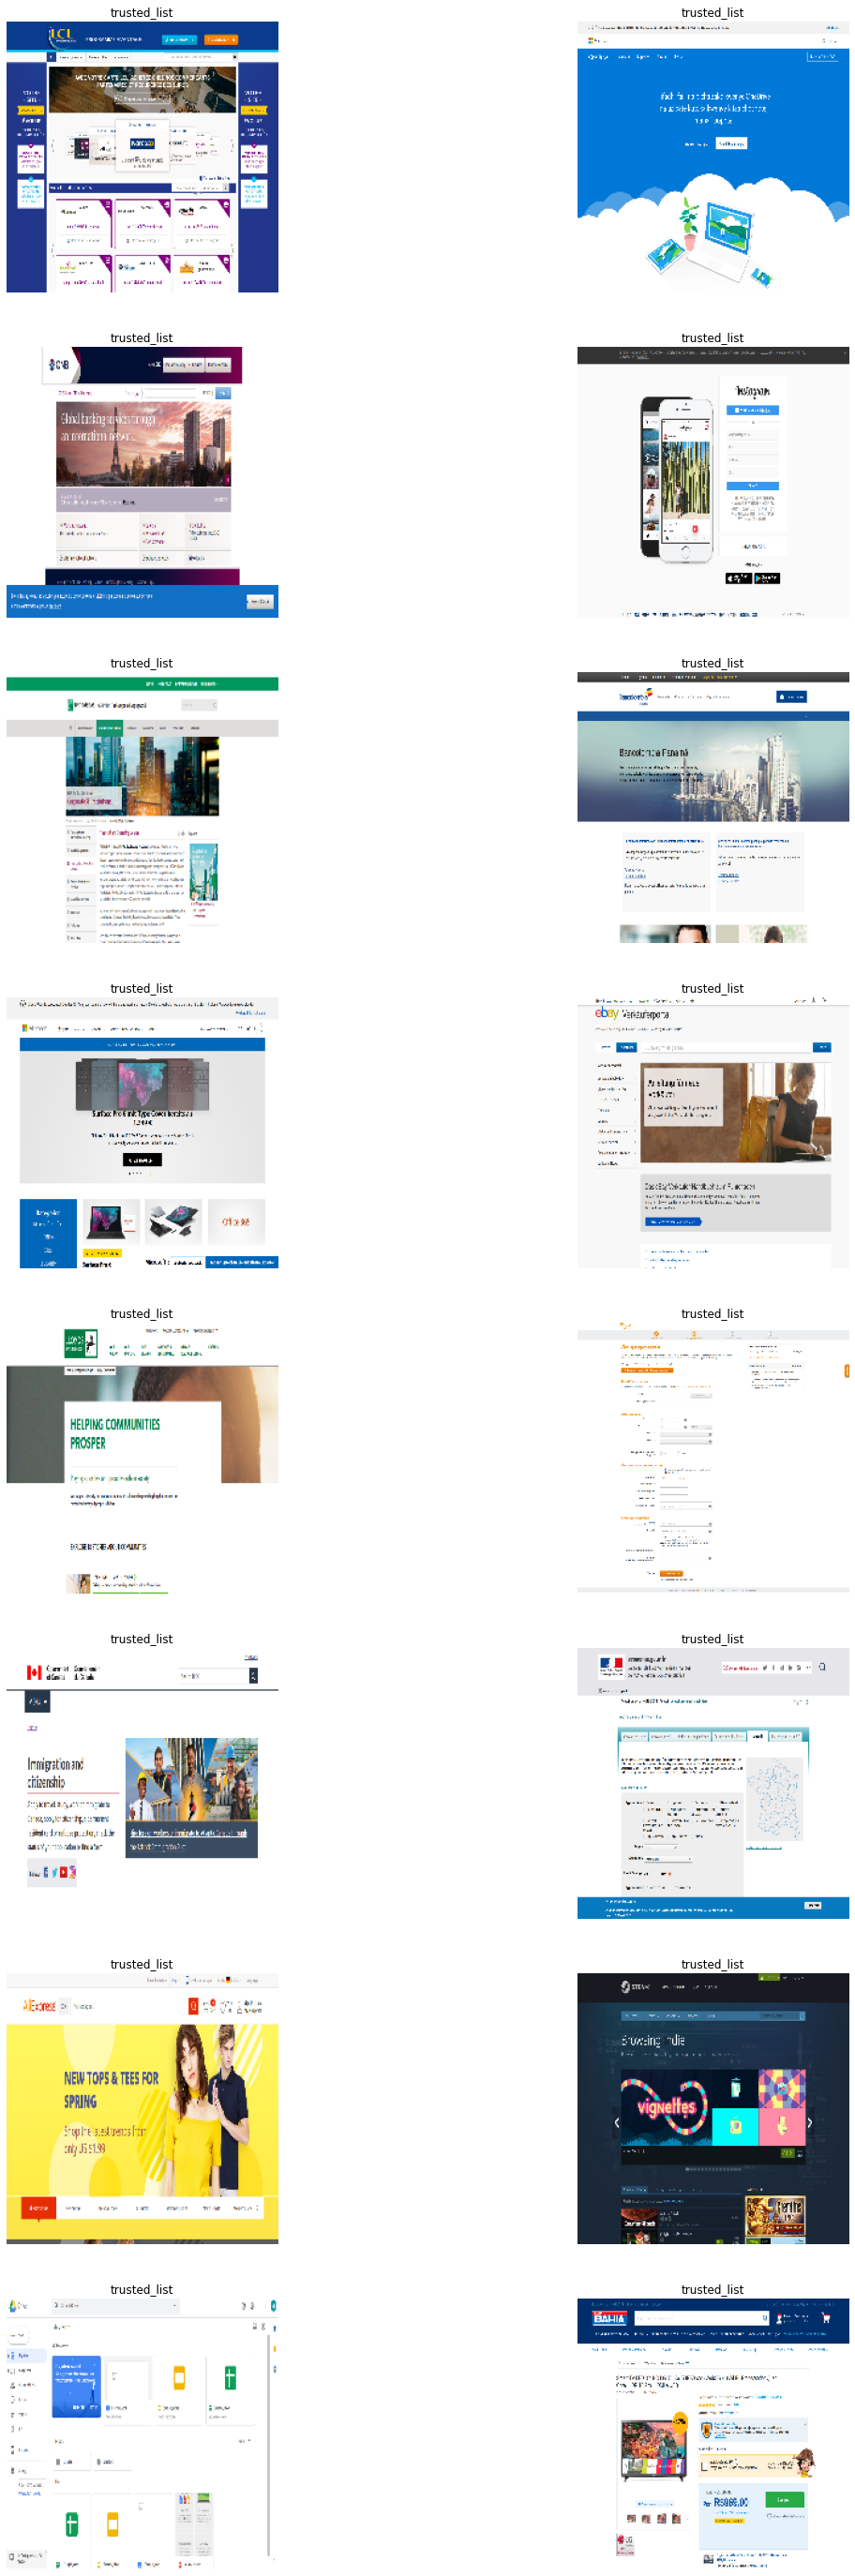

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Tune dataset

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(20).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [14]:
input_tensor = layers.Input((img_width, img_height, 3))
x = keras.applications.vgg16.preprocess_input(input_tensor)
vgg_model = keras.applications.vgg16.VGG16(weights=None)
vgg_output = vgg_model(x)
output_tensor = layers.Dense(1)(vgg_output)
model = keras.Model(input_tensor, output_tensor)

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 138,358,545
Trainable params: 138,358,545
Non-trainable params: 0
_________________________________________________________________


In [17]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Training

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [19]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/20
264/264 [==============================] - 155s 309ms/step - loss: 0.5878 - accuracy: 0.1871 - val_loss: 0.5203 - val_accuracy: 0.8857

Epoch 00001: val_loss improved from inf to 0.52031, saving model to ..\phi_checkpoints\2021-07-25_21;43;09.524444_vgg16_valacc0.8857_e1
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-07-25_21;43;09.524444_vgg16_valacc0.8857_e1\assets
Epoch 2/20
264/264 [==============================] - 125s 239ms/step - loss: 0.4744 - accuracy: 0.8869 - val_loss: 0.4387 - val_accuracy: 0.8857

Epoch 00002: val_loss improved from 0.52031 to 0.43871, saving model to ..\phi_checkpoints\2021-07-25_21;43;09.524444_vgg16_valacc0.8857_e2
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-07-25_21;43;09.524444_vgg16_valacc0.8857_e2\assets
Epoch 3/20
264/264 [==============================] - 125s 240ms/step - loss: 0.4139 - accuracy: 0.8869 - val_loss: 0.3963 - val_accuracy: 0.8857

Epoch 00003: val_loss improved from 0.43871 to 0.39628, saving 

## Save model

In [20]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}_w{img_width}_h{img_height}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\phi_models\2021-07-25_21;43;09.524444_vgg16_valacc0.8857_e14_b32_w224_h224.tf\assets


## Load model

In [21]:
# change filename to the model you want to load
model_filename = "2021-07-25_17;29;24.257896_custom2_valacc0.8853_e8_b16_w224_h224.tf"
model2 = keras.models.load_model(
    model_dir / model_filename,
    compile=True)

## Load model checkpoint

In [35]:
checkpoint_filename = "2021-07-25_21;43;09.524444_vgg16_valacc0.8857_e11"
model2 = keras.models.load_model(
    checkpoint_dir / checkpoint_filename,
    compile=True)

## Visulaize loss and acc

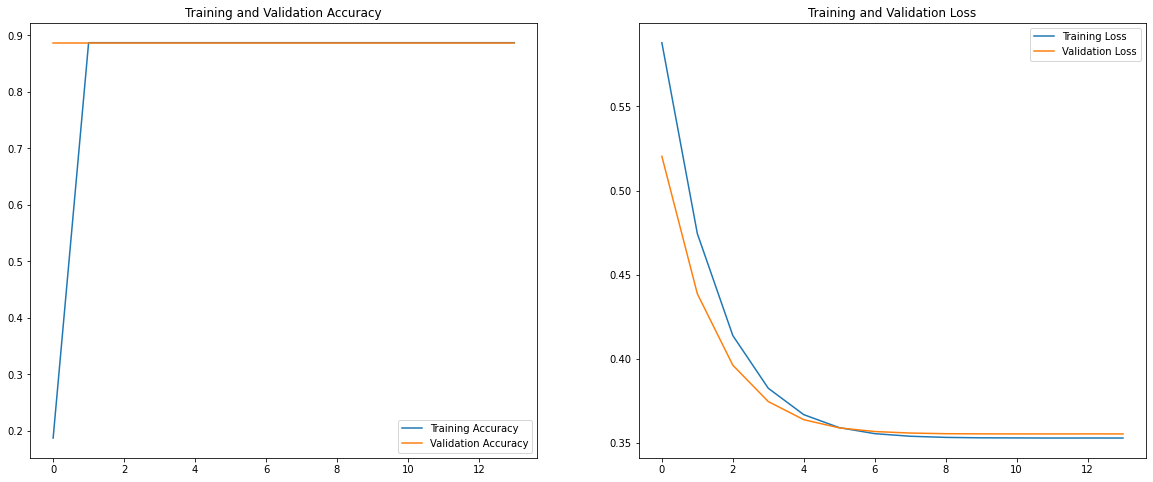

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [36]:
val_results = model2.evaluate(val_ds)
print("val loss, val acc:", val_results)

66/66 [==============================] - 19s 260ms/step - loss: 0.3555 - accuracy: 0.8857
val loss, val acc: [0.3554667830467224, 0.8856736421585083]
